In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import sklearn, xgboost, uproot
from scipy import stats
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import JFuncs
import umap
import dill
sns.set()

def hist(dat,bins=100):
    plt.figure(figsize=(10,5))
    plt.hist(dat,bins,histtype="step")
    plt.show()
def hists(dats,bins=100):
    plt.figure(figsize=(10,5))
    for d in dats:
        plt.hist(d,bins,histtype="step")
    plt.show()
    
def tf(d):
    return d[dat["trueKs"].astype(bool)],d[~dat["trueKs"].astype(bool)]


def preprocess(l):
    return (l-np.mean(l))/np.std(l)
shap = "cosTheta v0_ks_mass pT v0_rxyErr v0_rxy v0_chi2 ntrk_pv0 eventCounter a0 a0xy pv0_y calpha v0_ks_massErr epsilon1 epsilon2 v0_ptErr v0_p v0_pz1 v0_phi2 v0_y".split(" ")


In [4]:
bigDat = True

if bigDat:
    path = "CernData/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
    dat_amount = 2*1e6

    file = uproot.open(path)
    tree = file['tree']
    dat = tree.pandas.df(shap+["trueKs"], entrystop=dat_amount)
#     df_all = tree.pandas.df(entrystop = dat_amount)
else:
    path = "dataframe_v0_mc.dat"
    dat = pd.read_pickle(path)

# print([head for head in dat])

In [5]:
if True:
    path = "CernData/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
    dat_amount = 1e12

    file = uproot.open(path)
    tree = file['tree']
    truedat = tree.pandas.df(shap, entrystop=dat_amount)


1 81821.0
2 46744.0
3 3928.0
4 2089.0
1 83927.0
2 48865.0
3 5473.0
4 3079.0
Made UMAP
Fittet UMAP
Transformed UMAP


C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


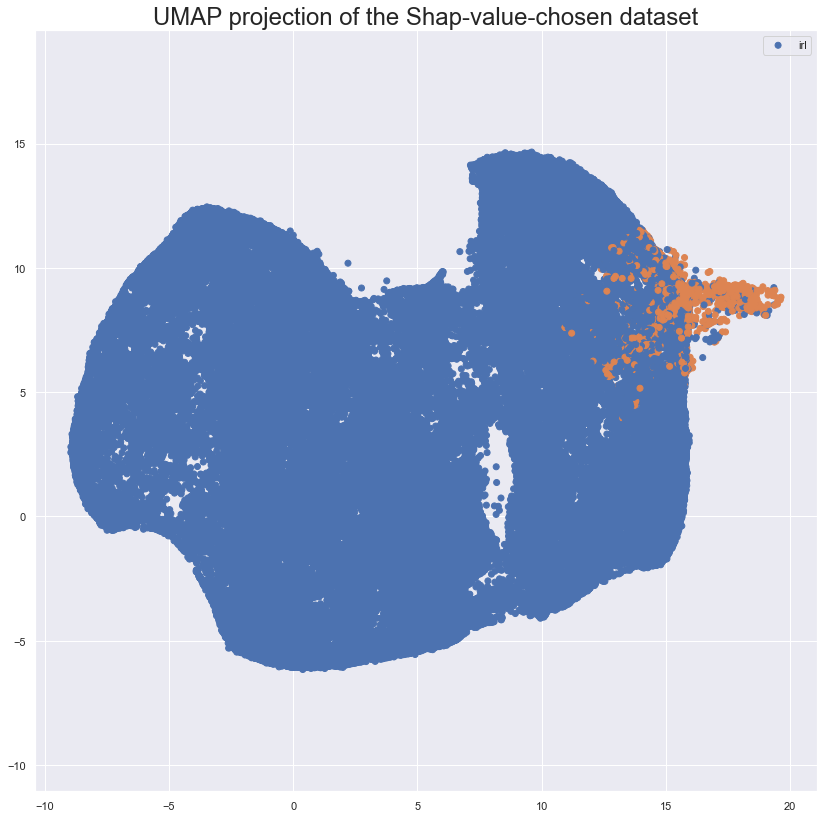

Plottet UMAP


In [34]:
rxy_low_min, rxy_high_min, chi2_high_min, cos_Theta_low_min, mass_low_min, mass_high_min = -60.818,114.783,3.782,0.9976,450,550
#tak nn
def cutter(df):
    label = np.ones(len(df))
    label[np.logical_or(df['v0_rxy'] < rxy_low_min, df['v0_rxy'] > rxy_high_min)] = 0
    print(1,sum(label))
    label[df['v0_chi2'] > chi2_high_min] = 0
    print(2,sum(label))
    
    label[df['cosTheta'] < cos_Theta_low_min] = 0
    print(3,sum(label))
    
    label[np.logical_or(df['v0_ks_mass'] < mass_low_min, df['v0_ks_mass'] > mass_high_min)] = 0
    print(4,sum(label))
    
    return label



ps = "v0_rxy v0_chi2 cosTheta v0_ks_mass".split(" ")

amount = int(1e5)

td = (truedat[ps])[:amount]

td_test = (truedat[ps])[amount:int(amount*2)]

target = cutter(td).astype(bool)#pd.Series(cutter(td), dtype = bool)

test_target = cutter(td_test).astype(bool)#pd.Series(cutter(td_test), dtype = bool)

td,td_test = preprocess(td),preprocess(td_test)
# dn = preprocess(dat[gg]).dropna()[:amount]




# target = dat["trueKs"][:amount]

# sns.pairplot(preprocess(dat[shap[:7]+["trueKs"]]), hue='trueKs')#,palette='Pastel1')
# plt.plot()
reducer = umap.UMAP(n_neighbors=20)

print("Made UMAP")

mapper = reducer.fit(td,y =target)

print("Fittet UMAP")

tembedding = mapper.transform(td_test)


print("Transformed UMAP")

# print(embedding.shape)


plt.figure(figsize=(14,14))

plt.scatter(
    tembedding[:, 0],
    tembedding[:, 1],
    c=[sns.color_palette()[x] for x in test_target],
    cmap='Spectral',
#     marker = '*',
#     s=5,
    alpha=1,
    label="irl"
    )

# plt.scatter(
#     tembedding[:, 0],
#     tembedding[:, 1],
# #     c=[sns.color_palette()[x] for x in target],
#     c='red',
#     s=0.1,
#     label="irl"
#     )



# Ks = mapper.transform(preprocess(dat[dat["trueKs"].astype(bool)][gg]).dropna())
# plt.scatter(
#     Ks[:, 0],
#     Ks[:, 1],
#     c="red",
#     marker = '*',
#     s=0.1
#     )


plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Shap-value-chosen dataset', fontsize=24)
plt.legend()
plt.show()
print("Plottet UMAP")


In [ ]:
cosmask = truedat["cosTheta"]>0.997

massk = np.logical_and(truedat["v0_ks_mass"]>400,truedat["v0_ks_mass"]<600)

msk = np.logical_and(cosmask,massk)
t,f = truedat["v0_ks_mass"][msk],truedat["v0_ks_mass"][~msk]


hist(t,200)

y,x = np.histogram(t,200)

bg = lambda x,a,b: x*a+b
func = lambda x,mu,sigma,a,b: stats.norm.pdf(x,mu,sigma)*a+b

fig, ax = plt.subplots(figsize=(13,6))
x = x[:-1]
mi,ax = JFuncs.chi2fit(x,y,np.sqrt(y),bg,{"a":100,"b":80},ax=ax,text=(.1,.4))
plt.show()
fig, ax = plt.subplots(figsize=(13,6))

y = y.astype(float)-bg(x,*mi.args)+500
JFuncs.chi2fit(x,y,np.sqrt(y),func,{"mu":490,"sigma":3,"a":2400,"b":10},ax=ax,text=(.1,.4))
plt.show()


**Testing the calculated uncertainty:**

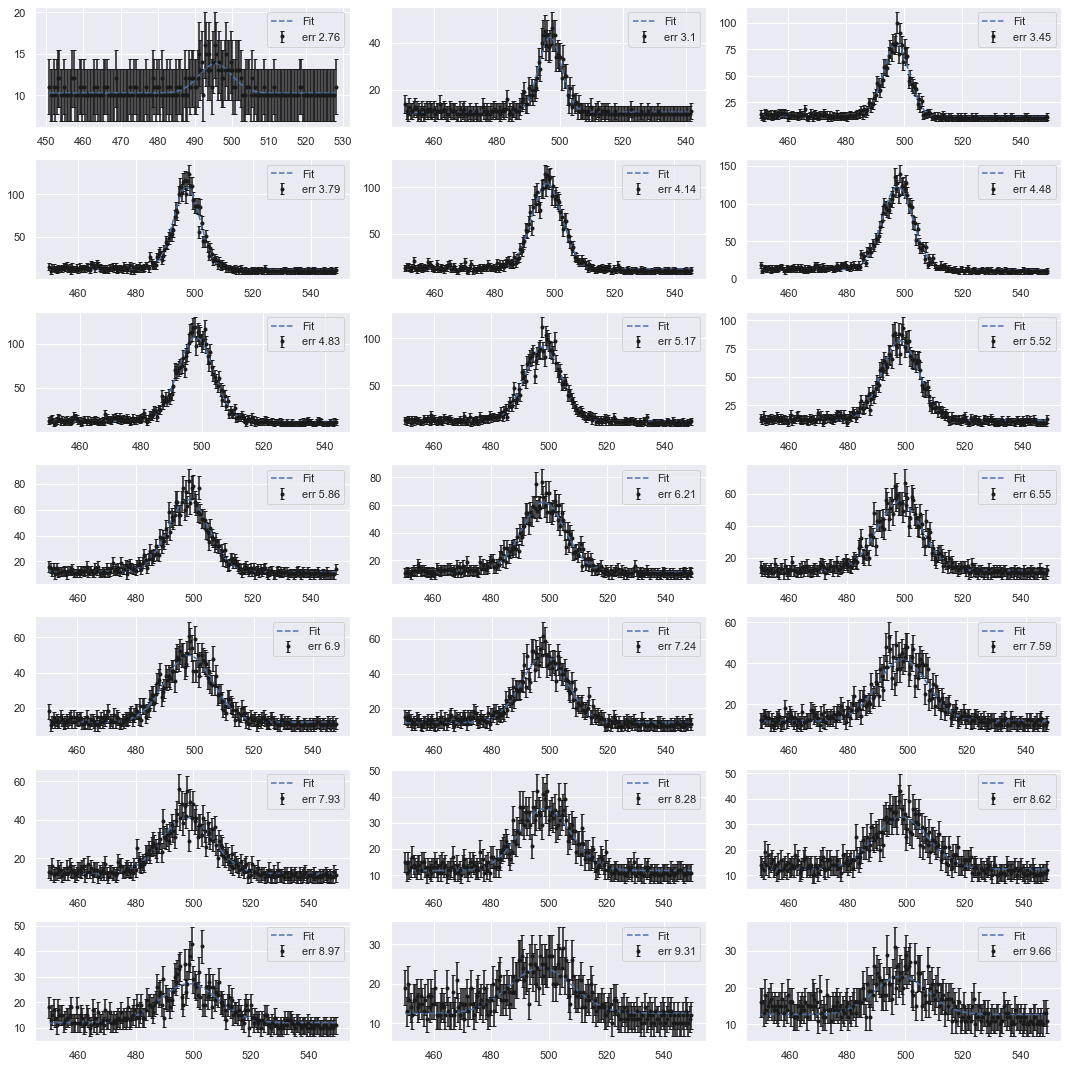

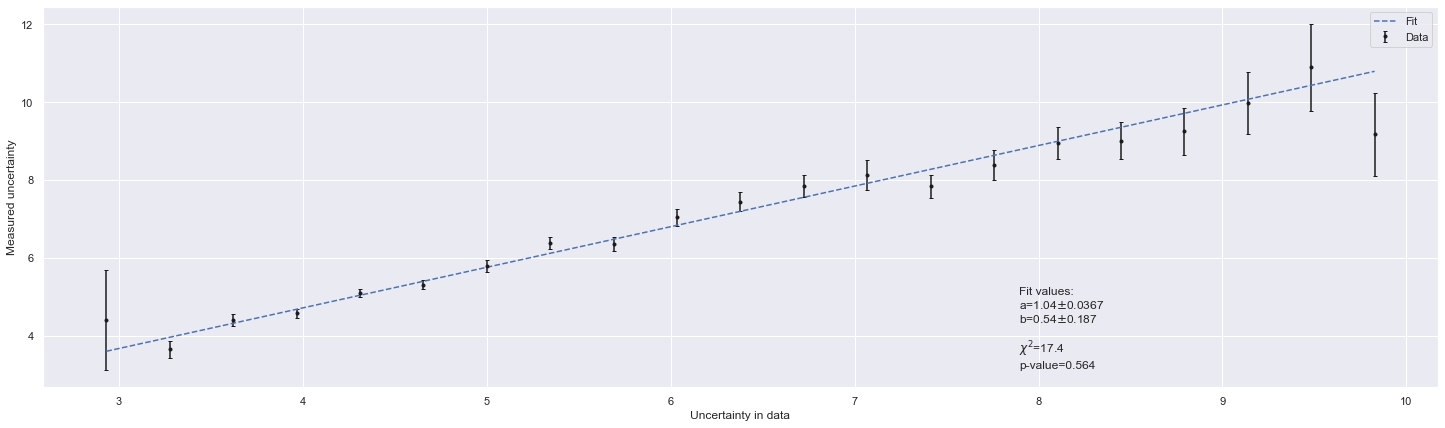

In [14]:


d = truedat
# d = dat


errs = np.linspace(0,10,30)
mis = []
xs = []
cosmask = d["cosTheta"]>0.997

massk = np.logical_and(d["v0_ks_mass"]>450,d["v0_ks_mass"]<550)

msk = np.logical_and(cosmask,massk)
t,f = d["v0_ks_mass"][msk],d["v0_ks_mass"][~msk]

fig, axs = plt.subplots(7,3,figsize=(15,15))
dri = 0
axs=axs.flatten()
for i in range(len(errs)-1):
    rng = np.logical_and(d['v0_ks_massErr']>errs[i],d['v0_ks_massErr']<errs[i+1])
    l = len(t[rng])
    y,x = np.histogram(t[rng],200)
    fffyyy = y
    if(l>100):
#         print(l)
#         xs.append(errs[i])
        bg = lambda x,a,b: x*a+b
        func = lambda x,mu,sigma,a,b: stats.norm.pdf(x,mu,sigma)*a+b

        x = x[:-1]
#         mi,ax = JFuncs.chi2fit(x,y,np.sqrt(y),bg,{"a":10,"b":80},draw=False)
#         y = y.astype(float)-bg(x,*mi.args)
        y -= np.min(y)-10
        mi, ax = JFuncs.chi2fit(x,y,np.sqrt(y),func,{"mu":492,"sigma":errs[i],"a":100,"b":10},ax=axs[dri],draw=True,label="err {:.3}".format(errs[i]))
        dri+=1
        if mi.migrad_ok():
            mis.append(mi)
            xs.append((errs[i+1]+errs[i])/2)
            
vals = [m.values["sigma"] for m in mis]
verrs = [m.errors["sigma"] for m in mis]
fig.tight_layout()
plt.show()
fig,ax = plt.subplots(figsize=(25,7))
mi, ax = JFuncs.chi2fit(xs,vals,verrs,bg,{"a":1,"b":0},draw=True,ax=ax,text=(0.7,0.05))
# plt.plot(xs,vals,'.')

plt.ylabel("Measured uncertainty")
plt.xlabel("Uncertainty in data")

plt.show()

In [35]:
p1 = "cosTheta pT v0_rxyErr v0_rxy v0_chi2 ntrk_pv0 a0 a0xy pv0_y calpha".split(" ")

p2 = "v0_ks_massErr epsilon1 epsilon2 v0_ptErr v0_p v0_pz1 v0_phi2 v0_y".split(" ")

ps = p1+p2

models =[]
tsts =[]

X,Y = dat[ps],dat[["trueKs"]]

X = preprocess(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
eval_s = [(X_train, y_train), (X_test, y_test)]
tsts.append(X_train)
model = xgboost.XGBClassifier(learning_rate = 0.01,n_estimators = 50)
model.fit(X_train, y_train,verbose=5,eval_set=eval_s,early_stopping_rounds=15,eval_metric ="auc")
y_pred = model.predict(X_test)
models.append(model)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
results = model.evals_result()

print("Accuracy: {:.3}".format(accuracy * 100.0))
print("AUC: {:.3}".format(np.max(results['validation_0']['auc'])))




C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[0]	validation_0-auc:0.978647	validation_1-auc:0.97766
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[5]	validation_0-auc:0.982018	validation_1-auc:0.98122
[10]	validation_0-auc:0.982398	validation_1-auc:0.981595
[15]	validation_0-auc:0.983884	validation_1-auc:0.983501
[20]	validation_0-auc:0.983908	validation_1-auc:0.983518
[25]	validation_0-auc:0.984172	validation_1-auc:0.983783
[30]	validation_0-auc:0.985823	validation_1-auc:0.985586
[35]	validation_0-auc:0.985955	validation_1-auc:0.985719
[40]	validation_0-auc:0.98618	validation_1-auc:0.98592
[45]	validation_0-auc:0.986393	validation_1-auc:0.986149
[49]	validation_0-auc:0.986579	validation_1-auc:0.986333
Accuracy: 98.0
AUC: 0.987


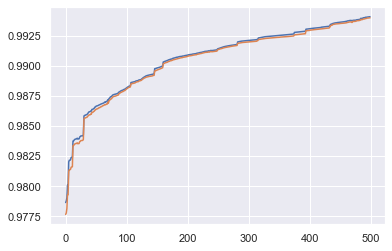

In [6]:
plt.plot(results['validation_0']['auc'], label='Train')
plt.plot(results['validation_1']['auc'], label='Train')
# plt.yscale("log")
plt.show()


Test on real data

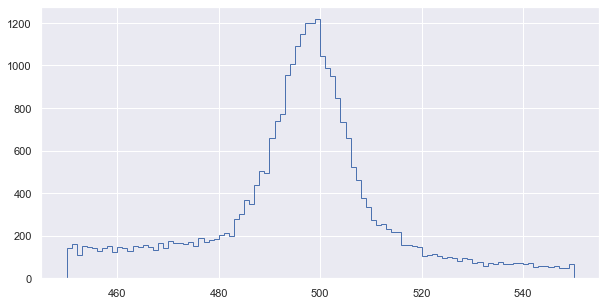

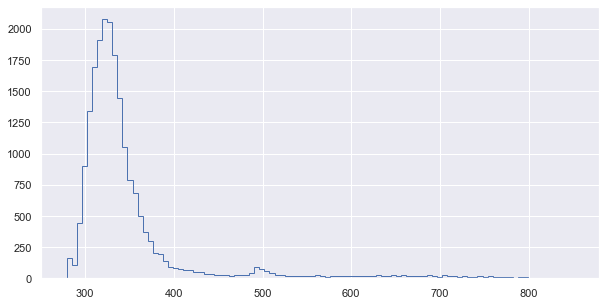

In [51]:
d = truedat[:int(1e6)]
y_pred = model.predict(d[ps])
dpred = d[y_pred.astype(bool)]

# dpred = dpred[dpred["cosTheta"]>0.997]
d = d[d["cosTheta"]>0.997]
# dpred = dpred[np.logical_and(dpred["v0_ks_mass"]>450,dpred["v0_ks_mass"]<550)]
d = d[np.logical_and(d["v0_ks_mass"]>450,d["v0_ks_mass"]<550)]

hist(d["v0_ks_mass"])
plt.show()
hist(dpred["v0_ks_mass"])